In [12]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import dataset
import numpy as np
import pickle
from cautious_extrapolation.data_paths import DATA_PATHS 
from cautious_extrapolation.utils import get_imagenet_features, kl_divergence_gaussian
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:

val_dataset = dataset.DatasetVal(DATA_PATHS["nfs"]["SkinLesionPixels"])
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

ood_dataset = dataset.DatasetTest(DATA_PATHS["nfs"]["SkinLesionPixels"])
ood_loader = torch.utils.data.DataLoader(dataset=ood_dataset, batch_size=32, shuffle=True)

(1164,)
(1164, 64, 64, 3)
DatasetVal - number of images: 1164
21.0
4020.0
1027.3806
(2259,)
(2259, 64, 64, 3)
DatasetTest - number of images: 2259
15.0
3978.0
1242.1696


In [3]:
val_features = get_imagenet_features(val_loader)
ood_features = get_imagenet_features(ood_loader)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:

num_points = min(len(val_features), len(ood_features))
X = np.concatenate((val_features[:num_points], ood_features[:num_points]), axis=0)
y = np.concatenate((np.ones(num_points), np.zeros(num_points)), axis=0)
idxs = np.random.permutation(2*num_points) 
X = X[idxs]
y = y[idxs]

scores = []
for _ in range(10):
    clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=20, alpha=10))
    clf.fit(X[int(0.2*num_points):], y[int(0.2*num_points):])
    score = clf.score(X[:int(0.2*num_points)], y[:int(0.2*num_points)])
    scores.append(score)

In [5]:
np.mean(scores)

0.8008620689655173

In [6]:
plt.hist(val_dataset.labels)
plt.hist(ood_dataset.labels)

(array([314., 517., 421., 327., 272., 186., 101.,  75.,  29.,  17.]),
 array([  15. ,  411.3,  807.6, 1203.9, 1600.2, 1996.5, 2392.8, 2789.1,
        3185.4, 3581.7, 3978. ], dtype=float32),
 <BarContainer object of 10 artists>)

In [7]:
val_dataset.labels.mean()

1027.3806

In [8]:
val_dataset.labels.std()

735.5443

In [9]:
dir_path = os.path.dirname(os.path.abspath("__file__"))
dataset_types = ['train', 'ood']


run_names = ["nll_seed0_2023_06_02_17_31_41",
             "nll_seed1_2023_06_02_17_33_36",
             "nll_seed2_2023_06_02_17_48_28",
             "nll_seed3_2023_06_02_17_50_58",
             "nll_seed4_2023_06_05_15_50_36"]

train_kls_all = []
ood_kls_all = []
for run_name in run_names:
    with open(os.path.join(dir_path, "data", run_name, "outputs.pkl"), 'rb') as f:
        data = pickle.load(f)

    train_kls = kl_divergence_gaussian(data['train'][:, 0], data['train'][:, 1], val_dataset.labels.mean()*np.ones(len(data['train'])), val_dataset.labels.std()*np.ones(len(data['train'])))
    ood_kls = kl_divergence_gaussian(data['ood'][:, 0], data['ood'][:, 1], val_dataset.labels.mean()*np.ones(len(data['ood'])), val_dataset.labels.std()*np.ones(len(data['ood'])))
    train_kls_all.append(train_kls.mean())
    ood_kls_all.append(ood_kls.mean())

train_kls_all = np.array(train_kls_all)
ood_kls_all = np.array(ood_kls_all)

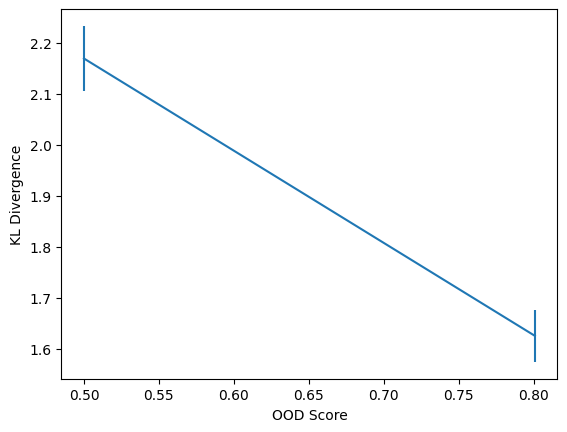

In [13]:
# plt.plot([0.5, np.mean(scores)], [train_kls_all.mean(), ood_kls_all.mean()])
plt.errorbar([0.5, np.mean(scores)], [train_kls_all.mean(), ood_kls_all.mean()], yerr=[train_kls_all.std(), ood_kls_all.std()])
plt.xlabel("OOD Score")
plt.ylabel("KL Divergence")
plt.show()